In [413]:
import numpy as np
import cv2
from hdrtool import hdr
import pandas as pd
import os
import importlib
import time
import matplotlib.pyplot as plt
import threading

In [414]:
IMGDIR = './images'
#META = './example/sample.csv'
META = './images/memorial.hdr_image_list.csv'

In [415]:
#df = pd.read_csv('./images/memorial.hdr_image_list.csv', sep='\s+') 
df = pd.read_csv(META, sep='\s+')

In [416]:
df

,Filename,1/shutter_speed,f/stop,gain(db),ND_filters
0,memorial0061.png,0.03125,8,0,0
1,memorial0062.png,0.06250,8,0,0
2,memorial0063.png,0.12500,8,0,0
3,memorial0064.png,0.25000,8,0,0
4,memorial0065.png,0.50000,8,0,0
5,memorial0066.png,1.00000,8,0,0
6,memorial0067.png,2.00000,8,0,0
7,memorial0068.png,4.00000,8,0,0
8,memorial0069.png,8.00000,8,0,0
9,memorial0070.png,16.00000,8,0,0


In [417]:
df['exposetime'] = 1/df['1/shutter_speed']

In [418]:
df.exposetime

0     32.000000
1     16.000000
2      8.000000
3      4.000000
4      2.000000
5      1.000000
6      0.500000
7      0.250000
8      0.125000
9      0.062500
10     0.031250
11     0.015625
12     0.007812
13     0.003906
14     0.001953
15     0.000977
Name: exposetime, dtype: float64

In [419]:
N = len(df)
imgs = []

In [420]:
for fn in df.Filename:
    imgs.append(cv2.imread(os.path.join(IMGDIR,fn)))

## Test

In [65]:
def expand_integer_grid(arr, n_classes):
    """

    :param arr: N dim array of size i_1, ..., i_N
    :param n_classes: C
    :returns: one-hot N+1 dim array of size i_1, ..., i_N, C
    :rtype: ndarray

    """
    one_hot = np.zeros(arr.shape + (n_classes,))
    axes_ranges = [range(arr.shape[i]) for i in range(arr.ndim)]
    flat_grids = [_.ravel() for _ in np.meshgrid(*axes_ranges, indexing='ij')]
    one_hot[flat_grids + [arr.ravel()]] = 1
    assert((one_hot.sum(-1) == 1).all())
    assert(np.allclose(np.argmax(one_hot, -1), arr))
    return one_hot

In [200]:
images = imgs
log_exposure_times = np.log(df.exposetime)
hdr_image = np.zeros(images[0].shape, dtype=np.float64)

channel = 2
# Collect the current layer of each input image from the exposure stack
layer_stack = [img[:, :, channel] for img in images]

# Sample image intensities
intensity_samples = hdr.sampleIntensities(layer_stack)

# Compute Response Curve
response_curve = hdr.computeResponseCurve(intensity_samples, log_exposure_times, 10, hdr.linearWeight)


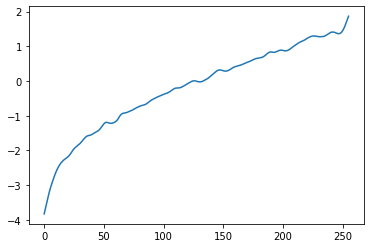

In [201]:
plt.plot(response_curve)

In [12]:
calibrateDebevec = cv2.createCalibrateDebevec()
responseDebevec = np.zeros((256, 1))
times = np.array(list(df.exposetime), dtype=np.float32)
responseDebevec= calibrateDebevec.process(src=imgs, dst=responseDebevec, times=times)

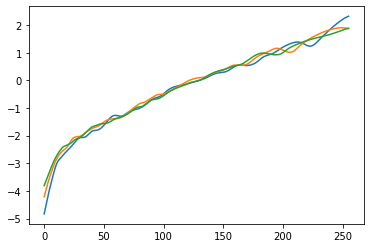

In [13]:
plt.plot(np.log(responseDebevec[:,:,0]))
plt.plot(np.log(responseDebevec[:,:,1]))
plt.plot(np.log(responseDebevec[:,:,2]))


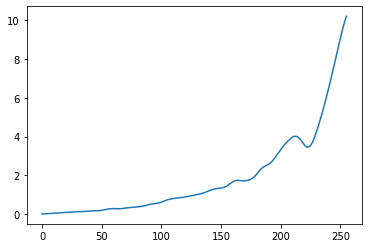

In [17]:
plt.plot(responseDebevec[:,:,0])

In [14]:
responseDebevec.shape

(256, 1, 3)

In [15]:
# Merge images into an HDR linear image
mergeDebevec = cv2.createMergeDebevec()
hdrDebevec = mergeDebevec.process(images, times, responseDebevec)
# Save HDR image.
cv2.imwrite("hdrDebevec.hdr", hdrDebevec)


True

In [16]:
# Tonemap using Drago's method to obtain 24-bit color image

tonemapDrago = cv2.createTonemapDrago(1.0, 0.7)
ldrDrago = tonemapDrago.process(hdrDebevec)
ldrDrago = 3 * ldrDrago
cv2.imwrite("ldr-Drago.jpg", ldrDrago * 255)


True

## Code Test

In [404]:
#relode module
importlib.reload(hdr)

<module 'hdrtool.hdr' from '/home/tsai/workspace/high-dynamic-range-image/hdrtool/hdr.py'>

In [171]:
images = imgs
times = np.array(list(df.exposetime), dtype=np.float32)
log_exposure_times = np.log(times)
smoothing_lambda = 10
"""Computational pipeline to produce the HDR images
----------
images : list<numpy.ndarray>
    A list containing an exposure stack of images
log_exposure_times : numpy.ndarray
    The log exposure times for each image in the exposure stack
smoothing_lambda : np.int (Optional)
    A constant value to correct for scale differences between
    data and smoothing terms in the constraint matrix -- source
    paper suggests a value of 100.
Returns
-------
numpy.ndarray
    The resulting HDR with intensities scaled to fit uint8 range
"""

num_channels = images[0].shape[2]
hdr_image = np.zeros(images[0].shape, dtype=np.float64)
res_curves = []

for channel in range(num_channels):
    print('channel:', channel)
    # Collect the current layer of each input image from the exposure stack
    layer_stack = [img[:, :, channel] for img in images]

    # Sample image intensities
    print('    sampling intensities...')
    otime = time.time()
    intensity_samples = hdr.sampleIntensities(layer_stack)
    print('    running time:', time.time()-otime)
    # Compute Response Curve
    print('    computing response curve...')
    otime = time.time()
    response_curve = hdr.computeResponseCurve(intensity_samples, log_exposure_times, smoothing_lambda, hdr.linearWeight)
    res_curves.append(response_curve)
    print('    running time:', time.time()-otime)
    
    
    # Build radiance map
    print('    building irradiance map using np...')
    otime = time.time()
    img_rad_map = hdr.computeRadianceMap_f(layer_stack, log_exposure_times, response_curve, hdr.linearWeight)
    print('    running time:', time.time()-otime)
    # Normalize hdr layer to (0, 255)
    #out = np.zeros(img_rad_map.shape)
    #cv2.normalize(src=img_rad_map, dst=out, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    #hdr_image[..., channel]  = out
    hdr_image[..., channel] = img_rad_map
    


channel: 0
    sampling intensities...
    running time: 0.4573359489440918
    computing response curve...
    running time: 0.49694252014160156
    building irradiance map using np...
    running time: 3.9870147705078125
channel: 1
    sampling intensities...
    running time: 0.4569356441497803
    computing response curve...
    running time: 0.4564814567565918
    building irradiance map using np...
    running time: 3.999573230743408
channel: 2
    sampling intensities...
    running time: 0.4582078456878662
    computing response curve...
    running time: 0.43903422355651855
    building irradiance map using np...
    running time: 3.999514579772949


In [395]:
np.exp(hdr_image.max())

547.4348195100039

In [394]:
hdr_image.min()

-1.470196372165589

In [401]:
image_mapped = hdr.globalToneMapping(hdr_image, Lwhite=30, alpha=0.9)
print('max:', image_mapped.max())

image shape: (324, 484, 3)
L bar: 15.101934224583049
max: 1.0054309322517878


In [402]:
#output = np.zeros(image_mapped.shape)
#output = cv2.normalize(src=image_mapped, dst=output, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
output = image_mapped

True

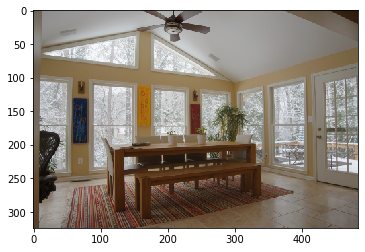

In [403]:
plt.imshow(cv2.cvtColor((output*255).astype(np.uint8), cv2.COLOR_BGR2RGB))
cv2.imwrite("ldr-myphoto.jpg", (output*255).astype(np.uint8) )

In [123]:
"""
# Merge images into an HDR linear image
responsecurve = np.swapaxes(np.array(res_curves, dtype=np.float32), 0, 1).reshape(256, 1,3)
plt.plot(responsecurve[:,:,0])
plt.plot(responsecurve[:,:,1])
plt.plot(responsecurve[:,:,2])
mergeDebevec = cv2.createMergeDebevec()
hdrDebevec = mergeDebevec.process(images, times, np.exp(responsecurve))
"""
# Save HDR image.
#cv2.imwrite("hdrDebevec.hdr", hdrDebevec)
tonemapDrago = cv2.createTonemapDrago(1.0, 0.7)
ldrDrago = tonemapDrago.process(np.exp(hdr_image))
#ldrDrago = tonemapDrago.process(hdr_image)
ldrDrago = 3 * ldrDrago
cv2.imwrite("ldr-myphoto.jpg", ldrDrago * 255)
cv2.imwrite("ldr-myphoto.jpg", ldrDrago )

True

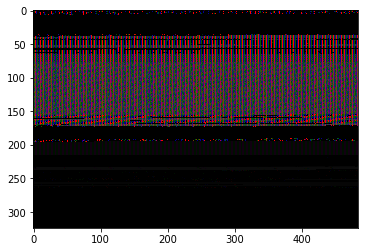

In [143]:
plt.imshow(cv2.cvtColor(ldrDrago, cv2.COLOR_BGR2RGB))

In [82]:
a = np.array([[4, 8, 10],[1, 2, 0.5]])
b = np.array([[-1, 9, 0],[11, -2, 0.5]])

In [84]:
c = a*b
print(c)

[[-4.   72.    0.  ]
 [11.   -4.    0.25]]


In [89]:
ap = np.ones((6, 15, 20))
dt = np.array(list(range(6)))
print(dt)

[0 1 2 3 4 5]


In [91]:
ans = dt[:, np.newaxis, np.newaxis]*ap

In [94]:
ans/(10*np.ones((6, 15, 20)))

array([[[0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        ...,
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 0. ]],

       [[0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1],
        [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1],
        [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1],
        ...,
        [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1],
        [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1],
        [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1]],

       [[0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
        [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
        [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
        ...,
        [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
        [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
        [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2]],

       [[0.3, 0.3, 0.3, ..., 0.3, 0.3, 0.3],
        [0.3, 0.3, 0.3, ..., 0.3, 0.3, 0.3],
        [0.3, 0.3, 0.3, ..., 0.3, 0.3, 0.3],
        ..

In [81]:
np.sum(a, axis=0)

array([ 5. , 10. , 10.5])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


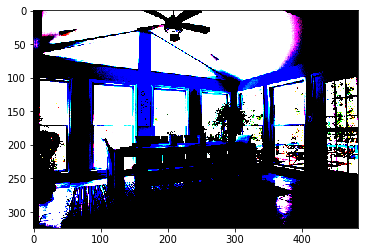

In [34]:
plt.imshow(hdrDebevec-20)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


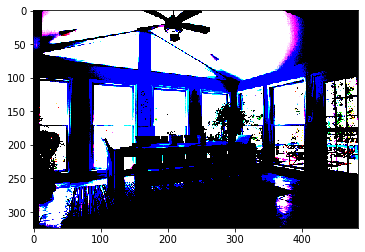

In [117]:
plt.imshow(np.exp(hdr_image)-20)

In [115]:
np.exp(hdr_image).max()

563.1441539284056

In [116]:
hdrDebevec.max()

616.24585

In [120]:
np.sum(np.abs(np.exp(hdr_image)-hdrDebevec))

459428.5399517924

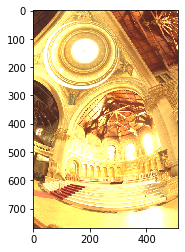

In [81]:
plt.imshow(cv2.cvtColor(cv2.imread(os.path.join('./images',df.Filename[0])), cv2.COLOR_BGR2RGB))

## Compute HDR

In [530]:
#relode module
importlib.reload(hdr)

<module 'hdrtool.hdr' from '/home/tsai/workspace/high-dynamic-range-image/hdrtool/hdr.py'>

In [531]:
hdrs = hdr.computeHDR(imgs, np.log(df.exposetime))

channel: 0
    sampling intensities...
    running time: 1.1167967319488525
    computing response curve...
    running time: 1.0056352615356445
    building irradiance map using np...
         dictG calculating time: 53.454609632492065
    running time: 53.661720752716064
channel: 1
    sampling intensities...
    running time: 1.1162407398223877
    computing response curve...
    running time: 0.9225718975067139
    building irradiance map using np...


KeyboardInterrupt: 

In [496]:
np.exp(hdrs.max())

992.940201540981

In [514]:
hdr_mapped = hdr.globalToneMapping(hdrs, Lwhite=np.exp(hdrs.max())*0.8, alpha=0.5)
print('max:', hdr_mapped.max())
print('min:', hdr_mapped.min())
hdr_mapped = ((hdr_mapped - hdr_mapped.min())*(255/(hdr_mapped.max()-hdr_mapped.min())))
print('max:', hdr_mapped.max())
print('min:', hdr_mapped.min())

image shape: (768, 512, 3)
L bar: 0.1265580519407992
max: 1.0059605116649197
min: 0.012101477482619092
max: 254.99999999999997
min: 0.0


True

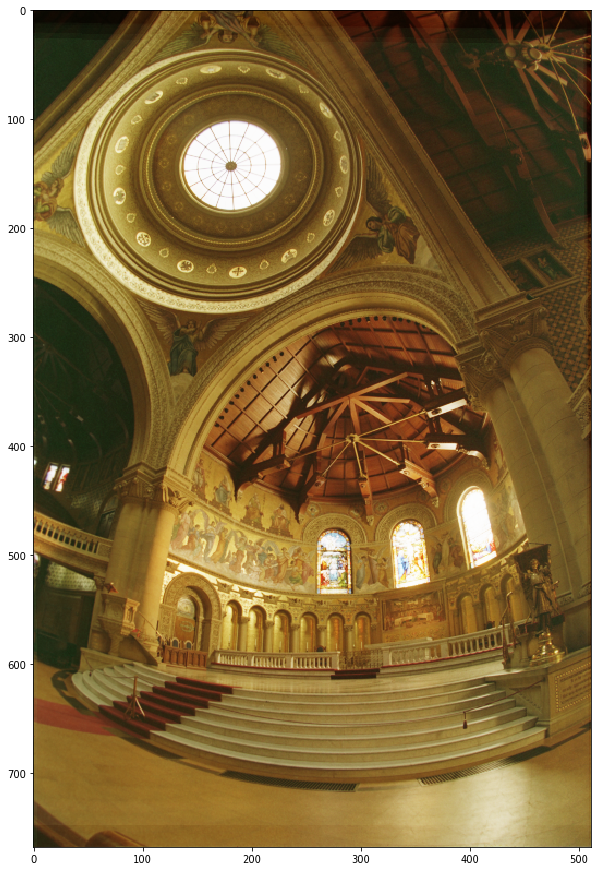

In [515]:
plt.figure(figsize=(10, 17))
plt.imshow(cv2.cvtColor((hdr_mapped).astype(np.uint8), cv2.COLOR_BGR2RGB))
cv2.imwrite("ldr-myphoto.jpg", (hdr_mapped).astype(np.uint8) )

In [140]:
hdrs

array([[[4, 5, 5],
        [4, 5, 5],
        [4, 5, 5],
        ...,
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1]],

       [[4, 5, 5],
        [4, 5, 5],
        [4, 5, 5],
        ...,
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1]],

       [[5, 5, 5],
        [5, 5, 5],
        [5, 5, 5],
        ...,
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1]],

       ...,

       [[1, 2, 3],
        [1, 2, 4],
        [1, 2, 3],
        ...,
        [5, 5, 5],
        [4, 4, 5],
        [4, 5, 5]],

       [[1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        ...,
        [4, 5, 5],
        [4, 5, 5],
        [4, 4, 5]],

       [[1, 2, 3],
        [1, 2, 3],
        [1, 2, 4],
        ...,
        [4, 4, 5],
        [4, 4, 5],
        [4, 4, 5]]], dtype=uint8)

In [465]:
x = np.array(list(range(1179648)))

In [466]:
mapping = np.array(list(range(0, -1179648, -1)))

In [467]:
dictmap = {}

In [468]:
for key, value in enumerate(mapping):
    dictmap[key] = value
    

In [469]:
print(mapping)

[       0       -1       -2 ... -1179645 -1179646 -1179647]


In [470]:
newx = [dictmap[i] for i in x]

In [463]:
nn = 768* 512* 3

In [464]:
nn

1179648

In [520]:
for i, a in enumerate(x):
    newx[i] = a